# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.30 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
# keep training awake
from workspace_utils import keep_awake
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
import numpy as np
import torch
from ddpg_agent import *
#from ddpg_agent_final import *

In [6]:
seed=0
n_episodes=2000 
max_t=1000
score_window=100
score_thresh=0.5
model_name=['actor_0_weights','critic_0_weights','actor_1_weights','critic_1_weights']

In [7]:
# Set up agents
agents = []
agents.append(Agent(state_size=state_size, action_size=action_size, random_seed=seed))
agents.append(Agent(state_size=state_size, action_size=action_size, random_seed=seed))

In [8]:
def maddpg_learn(n_episodes, max_t, model_name, score_window, score_thresh):
    scores = []
    brain_name = env.brain_names[0]
    # Loop per episode
    for i_episode in keep_awake(range(1, n_episodes+1)):
        env_info = env.reset(train_mode=True)[brain_name] # Reset environment
        states = env_info.vector_observations
        score = np.zeros(2)
        # Loop per action
        for t in range(max_t):
            action0 = np.array(agents[0].act(torch.from_numpy(states[0]).float()))
            action1 = np.array(agents[1].act(torch.from_numpy(states[1]).float()))
            env_info = env.step([action0, action1])[brain_name]
            next_states = np.array(env_info.vector_observations)
            dones = np.array(env_info.local_done)
            rewards = np.array(env_info.rewards)
            Agent.add_memory(states[0], action0, rewards[0], next_states[0], dones[0],
                         states[1], action1, rewards[1], next_states[1], dones[1])
            agents[0].step(0)
            agents[1].step(1)
            score += rewards
            states = next_states

            if any(dones):
                break 
        scores.append(np.max(score))
        avg_score = np.mean(scores[-score_window:])
        max_score = np.max(scores[-score_window:])
        print('\rEpisode {} \tAverage Score: {:.2f} \tMax score: {}'.format(i_episode, avg_score, max_score), end="")
        if i_episode % score_window == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score))
        if avg_score >= score_thresh and i_episode > score_window:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, avg_score))
            torch.save(agents[0].network.actor.state_dict(), model_name[0]+'.pth') 
            torch.save(agents[0].network.critic.state_dict(), model_name[1]+'.pth')
            torch.save(agents[1].network.actor.state_dict(), model_name[2]+'.pth') 
            torch.save(agents[1].network.critic.state_dict(), model_name[3]+'.pth')
            break

    return scores

In [ ]:
scores = maddpg_learn(n_episodes, max_t, model_name, score_window, score_thresh)

Episode 100	Average Score: 0.000 	Max score: 0.10000000149011612
Episode 200	Average Score: 0.000 	Max score: 0.09000000171363354
Episode 300	Average Score: 0.000 	Max score: 0.0
Episode 400	Average Score: 0.000 	Max score: 0.0
Episode 500	Average Score: 0.011 	Max score: 0.10000000149011612
Episode 600	Average Score: 0.022 	Max score: 0.10000000149011612
Episode 700	Average Score: 0.033 	Max score: 0.20000000298023224
Episode 800	Average Score: 0.088 	Max score: 0.20000000298023224
Episode 900	Average Score: 0.088 	Max score: 0.5000000074505806
Episode 1000	Average Score: 0.133 	Max score: 0.4000000059604645
Episode 1100	Average Score: 0.188 	Max score: 0.6000000089406967
Episode 1200	Average Score: 0.222 	Max score: 1.2000000178813934
Episode 1300	Average Score: 0.366 	Max score: 2.6000000387430191
Episode 1400	Average Score: 0.400 	Max score: 1.4000000208616257
Episode 1421 	Average Score: 0.41 	Max score: 1.4000000208616257

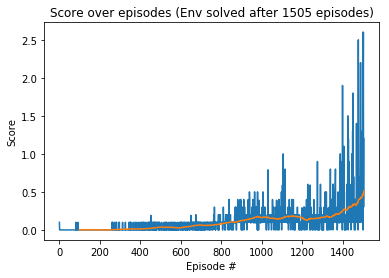

In [23]:
import pandas as pd
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(scores)), pd.Series(scores).rolling(window=100).mean())
plt.xlabel(x_axis)
plt.ylabel(y_axis)
plt.title('Score over episodes (Env solved after {} episodes)'.format(len(scores)))
plt.show()